In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#reading
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.head())
print(train_df.info())
print(train_df.isnull().sum().sort_values(ascending=False).head(20))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [3]:
#drop target and fixing na
train_df = train_df.dropna(subset=["SalePrice"])
null_thresh = 0.3
cols_to_drop = train_df.columns[train_df.isnull().mean() > null_thresh]
train_df_cleaned = train_df.drop(columns=cols_to_drop)
test_df_cleaned = test_df.drop(columns=cols_to_drop)


<Axes: ylabel='SalePrice'>

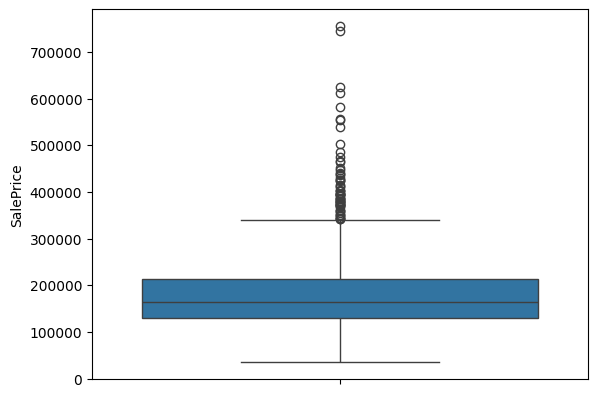

In [4]:
#Box plot
sns.boxplot(train_df_cleaned['SalePrice'])

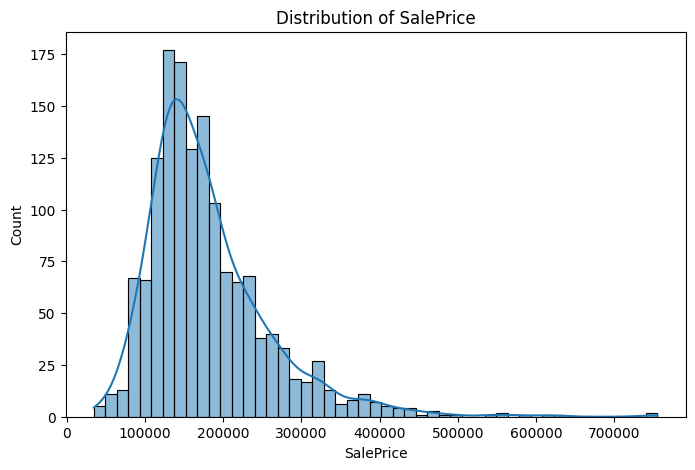

In [5]:
#distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(train_df_cleaned["SalePrice"], kde=True)
plt.title("Distribution of SalePrice")
plt.show()

In [6]:
#label encoding
for col in train_df_cleaned.select_dtypes(include="object").columns:
    if train_df_cleaned[col].nunique() == 2:
        le = LabelEncoder()
        train_df_cleaned[col] = le.fit_transform(train_df_cleaned[col].fillna("Missing"))
        test_df_cleaned[col] = test_df_cleaned[col].fillna("Missing")
        label_map = dict(zip(le.classes_, le.transform(le.classes_)))
        test_df_cleaned[col] = test_df_cleaned[col].map(label_map).fillna(-1).astype(int)

In [7]:
#outlier removal
num_cols = train_df_cleaned.select_dtypes(include=["int64", "float64"]).columns.drop("SalePrice")
for col in num_cols[:5]:
    q1 = train_df_cleaned[col].quantile(0.25)
    q3 = train_df_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    train_df_cleaned[col] = np.clip(train_df_cleaned[col], lower, upper)

In [8]:
#missing values
test_missing_values=test_df_cleaned.isnull().sum()
test_missing_values=test_missing_values[test_missing_values>0]
print(test_missing_values)

MSZoning          4
LotFrontage     227
Exterior1st       1
Exterior2nd       1
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtFinType2     42
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64


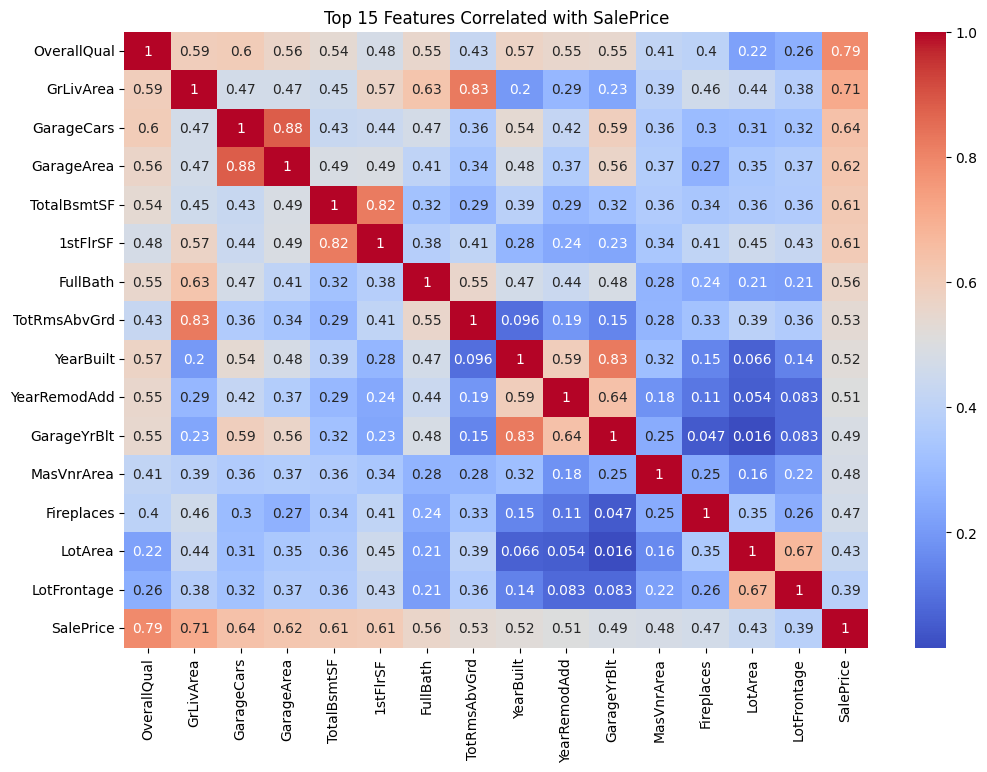

In [9]:
#correlation heatmap
numeric_df = train_df_cleaned.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr()

top_corr = corr["SalePrice"].abs().sort_values(ascending=False)[1:16]
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_cleaned[top_corr.index.tolist() + ["SalePrice"]].corr(), annot=True, cmap="coolwarm")
plt.title("Top 15 Features Correlated with SalePrice")
plt.show()

In [10]:
#Defining target and model training using linear regression pipeline
X = train_df_cleaned.drop("SalePrice", axis=1)
y = train_df_cleaned["SalePrice"]
X_test = test_df_cleaned.copy()

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

pipeline.fit(X, y)
test_preds = pipeline.predict(X_test)

submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_preds
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created!")


✅ submission.csv created!


In [11]:
# Create validation split
X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#Train model on train split
pipeline.fit(X_train_split, y_train_split)
#Predict on validation set
val_preds = pipeline.predict(X_val)
#r2 and RMSE
r2 = r2_score(y_val, val_preds)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"📊 Validation R² Score: {r2:.4f}")
print(f"📉 Validation RMSE: {rmse:.2f}")

📊 Validation R² Score: 0.8816
📉 Validation RMSE: 30131.86
